# 1.24c8: Gradient-Weight Change Correlation

**Back to basics.** Before trying to validate the full Adam formula, let's just look at the raw relationship between recorded gradients and measured weight changes.

We have:
- `W[t]` in bfloat16 (actual model weights)
- `grad_W[t]` in bfloat16 (recorded gradients)
- `ΔW[t] = W[t] - W[t-1]` (measured movement)

Questions:
1. Do gradients and ΔW point in opposite directions? (They should: ΔW ≈ -η·grad)
2. How strong is the correlation?
3. Does the relationship change over time?
4. Are there systematic differences between live and dead tokens?

## Parameters

In [1]:
FLANNEL_DATA_PATH = "../tensors/Flannel/1.20h_flannel_7.safetensors"
TOKEN_MASK_PATH = "../tensors/Flannel/live_dead_tokens.safetensors"

# Timesteps to examine in detail
TIMESTEPS = [1, 2, 5, 10, 20, 50, 100, 200, 500, 800]

# Random seed
RANDOM_SEED = 42

print("✓ Parameters set")

✓ Parameters set


## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
print(f"Loading Flannel 7 data: {FLANNEL_DATA_PATH}")
data = load_file(FLANNEL_DATA_PATH)

W = data['W'][0].to(device)  # (1001, 10000, 64)
grad_W = data['grad_W'][0].to(device)

n_steps = W.shape[0] - 1
vocab_size = W.shape[1]
hidden_dim = W.shape[2]

print(f"  W shape: {tuple(W.shape)}")
print(f"  Steps: {n_steps}")
print(f"  Vocabulary: {vocab_size:,}")
print(f"  Hidden dim: {hidden_dim}")
print()

print(f"Loading token masks: {TOKEN_MASK_PATH}")
mask_data = load_file(TOKEN_MASK_PATH)
live_mask = mask_data['live_mask'].bool().to(device)
dead_mask = mask_data['dead_mask'].bool().to(device)

n_live = live_mask.sum().item()
n_dead = dead_mask.sum().item()

print(f"  Live tokens: {n_live:,}")
print(f"  Dead tokens: {n_dead:,}")
print()
print("✓ Data loaded")

Loading Flannel 7 data: ../tensors/Flannel/1.20h_flannel_7.safetensors
  W shape: (1001, 10000, 64)
  Steps: 1000
  Vocabulary: 10,000
  Hidden dim: 64

Loading token masks: ../tensors/Flannel/live_dead_tokens.safetensors
  Live tokens: 6,301
  Dead tokens: 3,699

✓ Data loaded


## Compute ΔW

In [5]:
print("Computing ΔW = W[t] - W[t-1]...")

# Compute differences for all timesteps
delta_W = torch.zeros_like(W)
delta_W[1:] = W[1:] - W[:-1]

print(f"  ΔW shape: {tuple(delta_W.shape)}")
print(f"\n✓ ΔW computed")

Computing ΔW = W[t] - W[t-1]...
  ΔW shape: (1001, 10000, 64)

✓ ΔW computed


## 1. Cosine Similarity: grad vs ΔW

If ΔW ≈ -η·grad, then cosine similarity should be **negative** (opposite directions) and **strong** (close to -1).

In [6]:
print("Computing cosine similarity between grad[t] and ΔW[t]...")
print()

cosines_all = []
cosines_live = []
cosines_dead = []

for t in TIMESTEPS:
    dW = delta_W[t].float()
    g = grad_W[t].float()
    
    # Per-token cosine similarity
    dot_product = (dW * g).sum(dim=1)
    dW_norm = torch.norm(dW, dim=1)
    g_norm = torch.norm(g, dim=1)
    cosine = dot_product / (dW_norm * g_norm + 1e-10)
    
    # Statistics
    cos_all = cosine.median().item()
    cos_live = cosine[live_mask].median().item()
    cos_dead = cosine[dead_mask].median().item()
    
    cosines_all.append(cos_all)
    cosines_live.append(cos_live)
    cosines_dead.append(cos_dead)
    
    print(f"t={t:3d}: all={cos_all:+.3f}, live={cos_live:+.3f}, dead={cos_dead:+.3f}")

print("\n(Should be negative; close to -1 means strong anticorrelation)")
print("\n✓ Cosine similarities computed")

Computing cosine similarity between grad[t] and ΔW[t]...

t=  1: all=-0.811, live=-0.810, dead=-0.814
t=  2: all=-0.860, live=-0.755, dead=-0.871
t=  5: all=-0.911, live=-0.848, dead=-0.917
t= 10: all=-0.968, live=-0.957, dead=-0.969
t= 20: all=-0.980, live=-0.978, dead=-0.981
t= 50: all=-0.974, live=-0.945, dead=-0.978
t=100: all=-0.779, live=-0.716, dead=-0.785
t=200: all=-0.360, live=-0.575, dead=-0.339
t=500: all=-0.208, live=-0.413, dead=-0.172
t=800: all=+0.000, live=-0.250, dead=+0.000

(Should be negative; close to -1 means strong anticorrelation)

✓ Cosine similarities computed


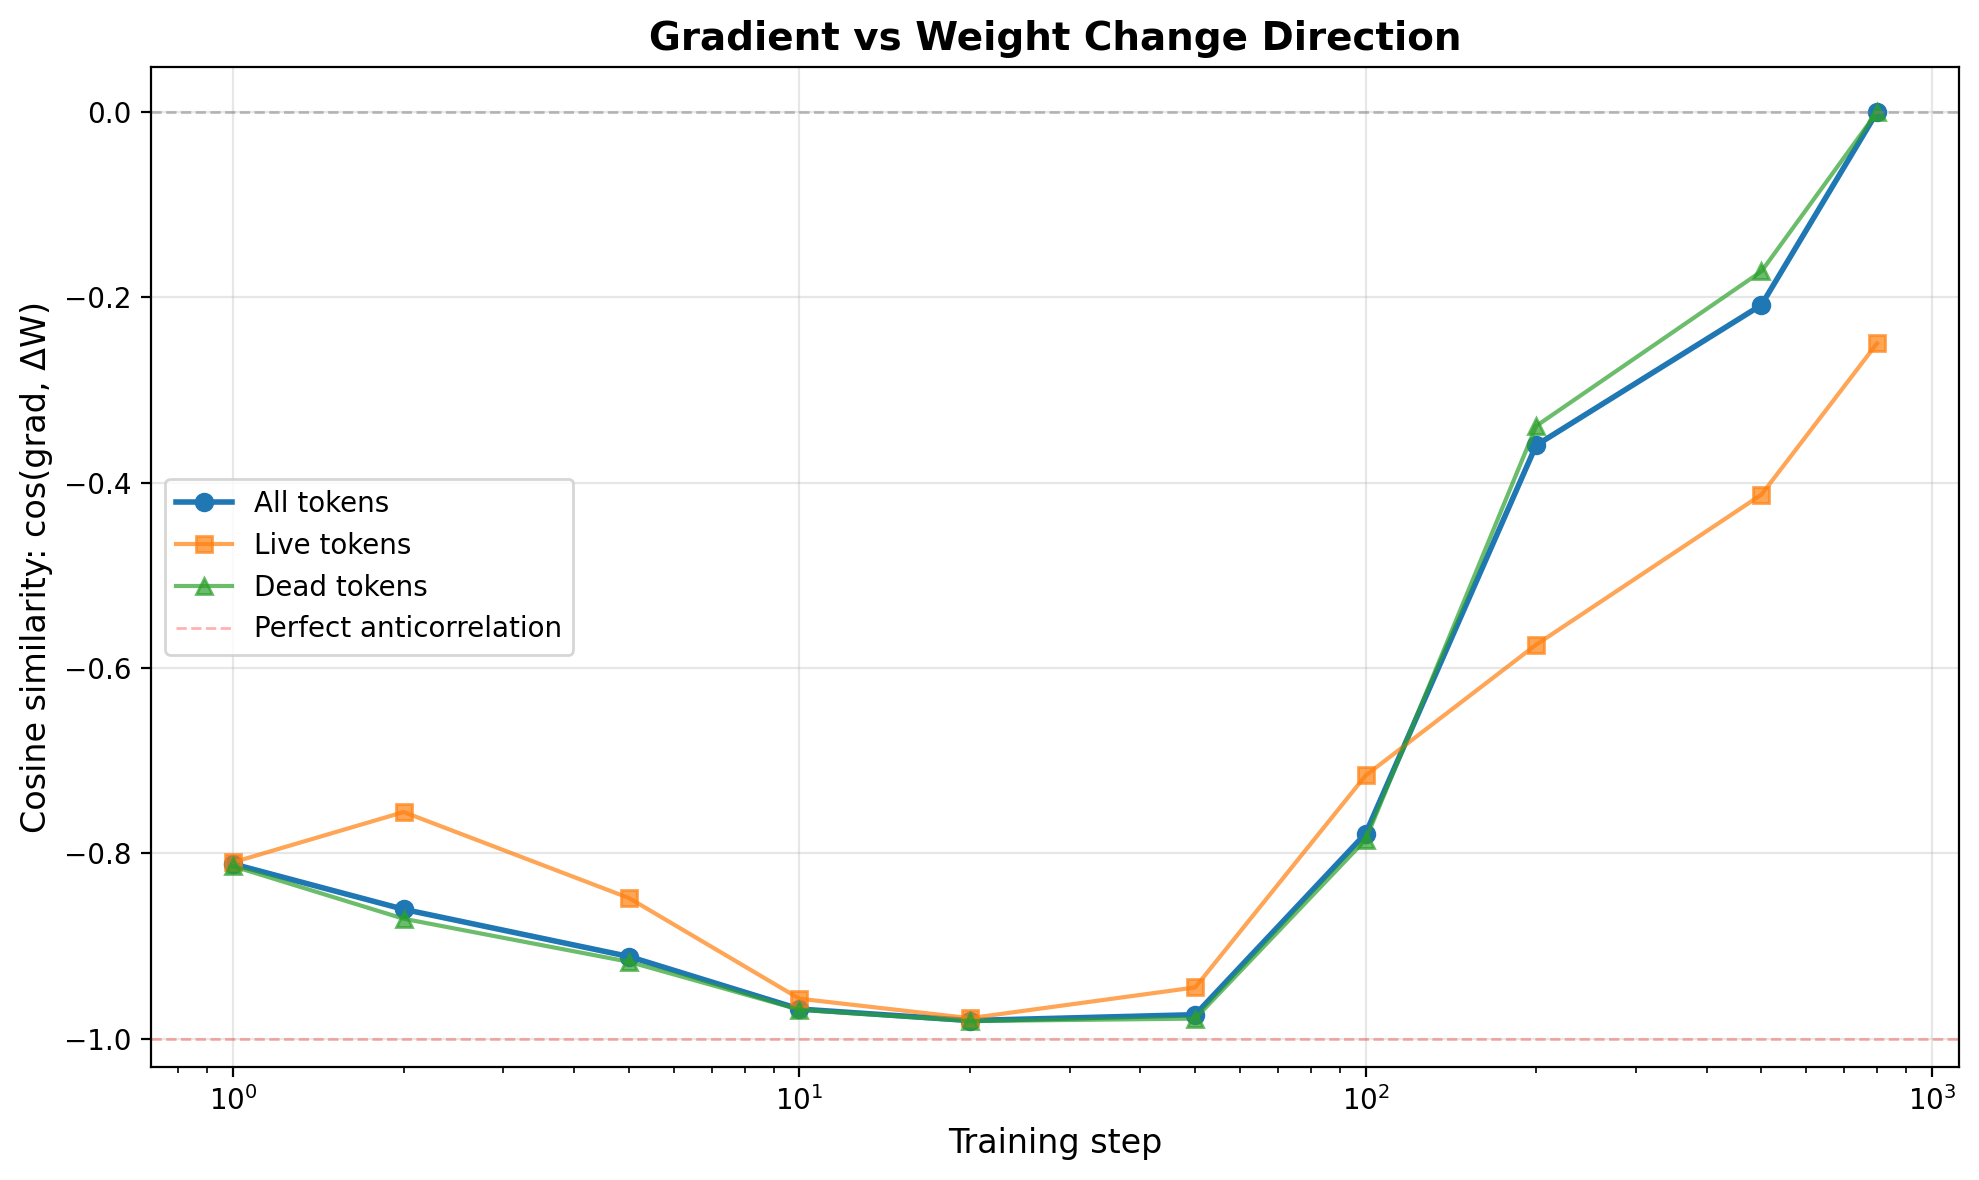

In [7]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

ax.plot(TIMESTEPS, cosines_all, 'o-', label='All tokens', linewidth=2)
ax.plot(TIMESTEPS, cosines_live, 's-', label='Live tokens', alpha=0.7)
ax.plot(TIMESTEPS, cosines_dead, '^-', label='Dead tokens', alpha=0.7)

ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axhline(-1, color='red', linestyle='--', linewidth=1, alpha=0.3, label='Perfect anticorrelation')

ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('Cosine similarity: cos(grad, ΔW)', fontsize=12)
ax.set_title('Gradient vs Weight Change Direction', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xscale('log')

plt.tight_layout()
plt.show()

## 2. Magnitude Ratio: ||ΔW|| / ||grad||

If ΔW ≈ -η·grad, this ratio should be approximately constant and close to the learning rate (0.001).

In [8]:
print("Computing magnitude ratio ||ΔW|| / ||grad||...")
print()

ratios_all = []
ratios_live = []
ratios_dead = []

for t in TIMESTEPS:
    dW = delta_W[t].float()
    g = grad_W[t].float()
    
    # Per-token ratio
    dW_norm = torch.norm(dW, dim=1)
    g_norm = torch.norm(g, dim=1)
    ratio = dW_norm / (g_norm + 1e-10)
    
    # Statistics (median, since there might be outliers)
    ratio_all = ratio.median().item()
    ratio_live = ratio[live_mask].median().item()
    ratio_dead = ratio[dead_mask].median().item()
    
    ratios_all.append(ratio_all)
    ratios_live.append(ratio_live)
    ratios_dead.append(ratio_dead)
    
    print(f"t={t:3d}: all={ratio_all:.6f}, live={ratio_live:.6f}, dead={ratio_dead:.6f}")

print("\n(Learning rate = 0.001, but Adam modifies this adaptively)")
print("\n✓ Magnitude ratios computed")

Computing magnitude ratio ||ΔW|| / ||grad||...

t=  1: all=76.801346, live=14.423666, dead=79.334846
t=  2: all=15.773429, live=11.635808, dead=16.841316
t=  5: all=9.188443, live=8.096561, dead=9.815728
t= 10: all=10.765973, live=8.356163, dead=12.094621
t= 20: all=13.989969, live=9.035725, dead=17.012716
t= 50: all=12.913404, live=5.085400, dead=29.027473
t=100: all=8.115373, live=2.784385, dead=36.812939
t=200: all=6.909108, live=2.530662, dead=21.310894
t=500: all=3.066814, live=2.023167, dead=13.815224
t=800: all=0.240528, live=0.498317, dead=0.000000

(Learning rate = 0.001, but Adam modifies this adaptively)

✓ Magnitude ratios computed


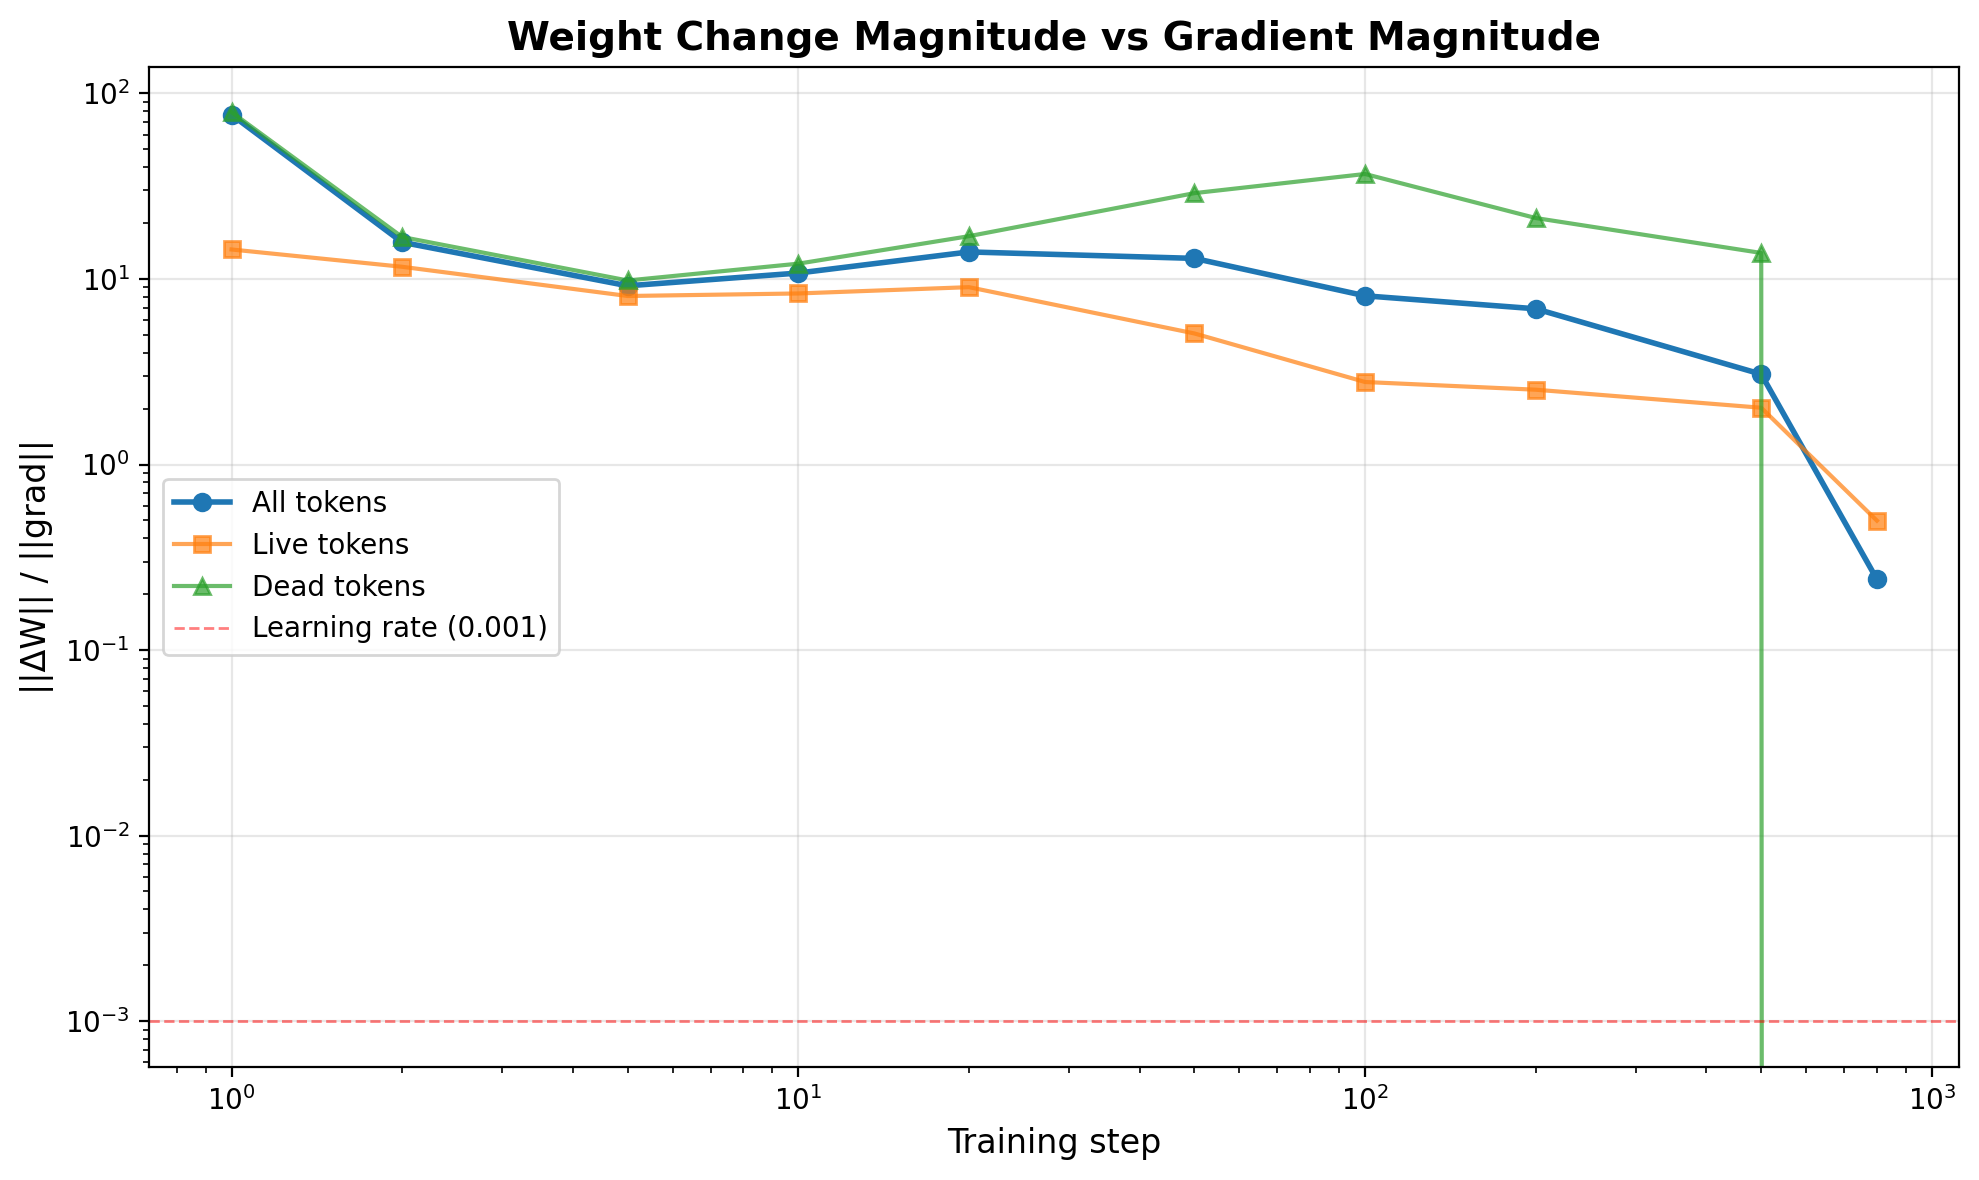

In [9]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

ax.plot(TIMESTEPS, ratios_all, 'o-', label='All tokens', linewidth=2)
ax.plot(TIMESTEPS, ratios_live, 's-', label='Live tokens', alpha=0.7)
ax.plot(TIMESTEPS, ratios_dead, '^-', label='Dead tokens', alpha=0.7)

ax.axhline(0.001, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Learning rate (0.001)')

ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('||ΔW|| / ||grad||', fontsize=12)
ax.set_title('Weight Change Magnitude vs Gradient Magnitude', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.show()

## 3. Component-wise Scatter: grad vs ΔW

Look at individual weight components at a few timesteps. If ΔW ≈ -η·grad, we should see a linear relationship with negative slope.

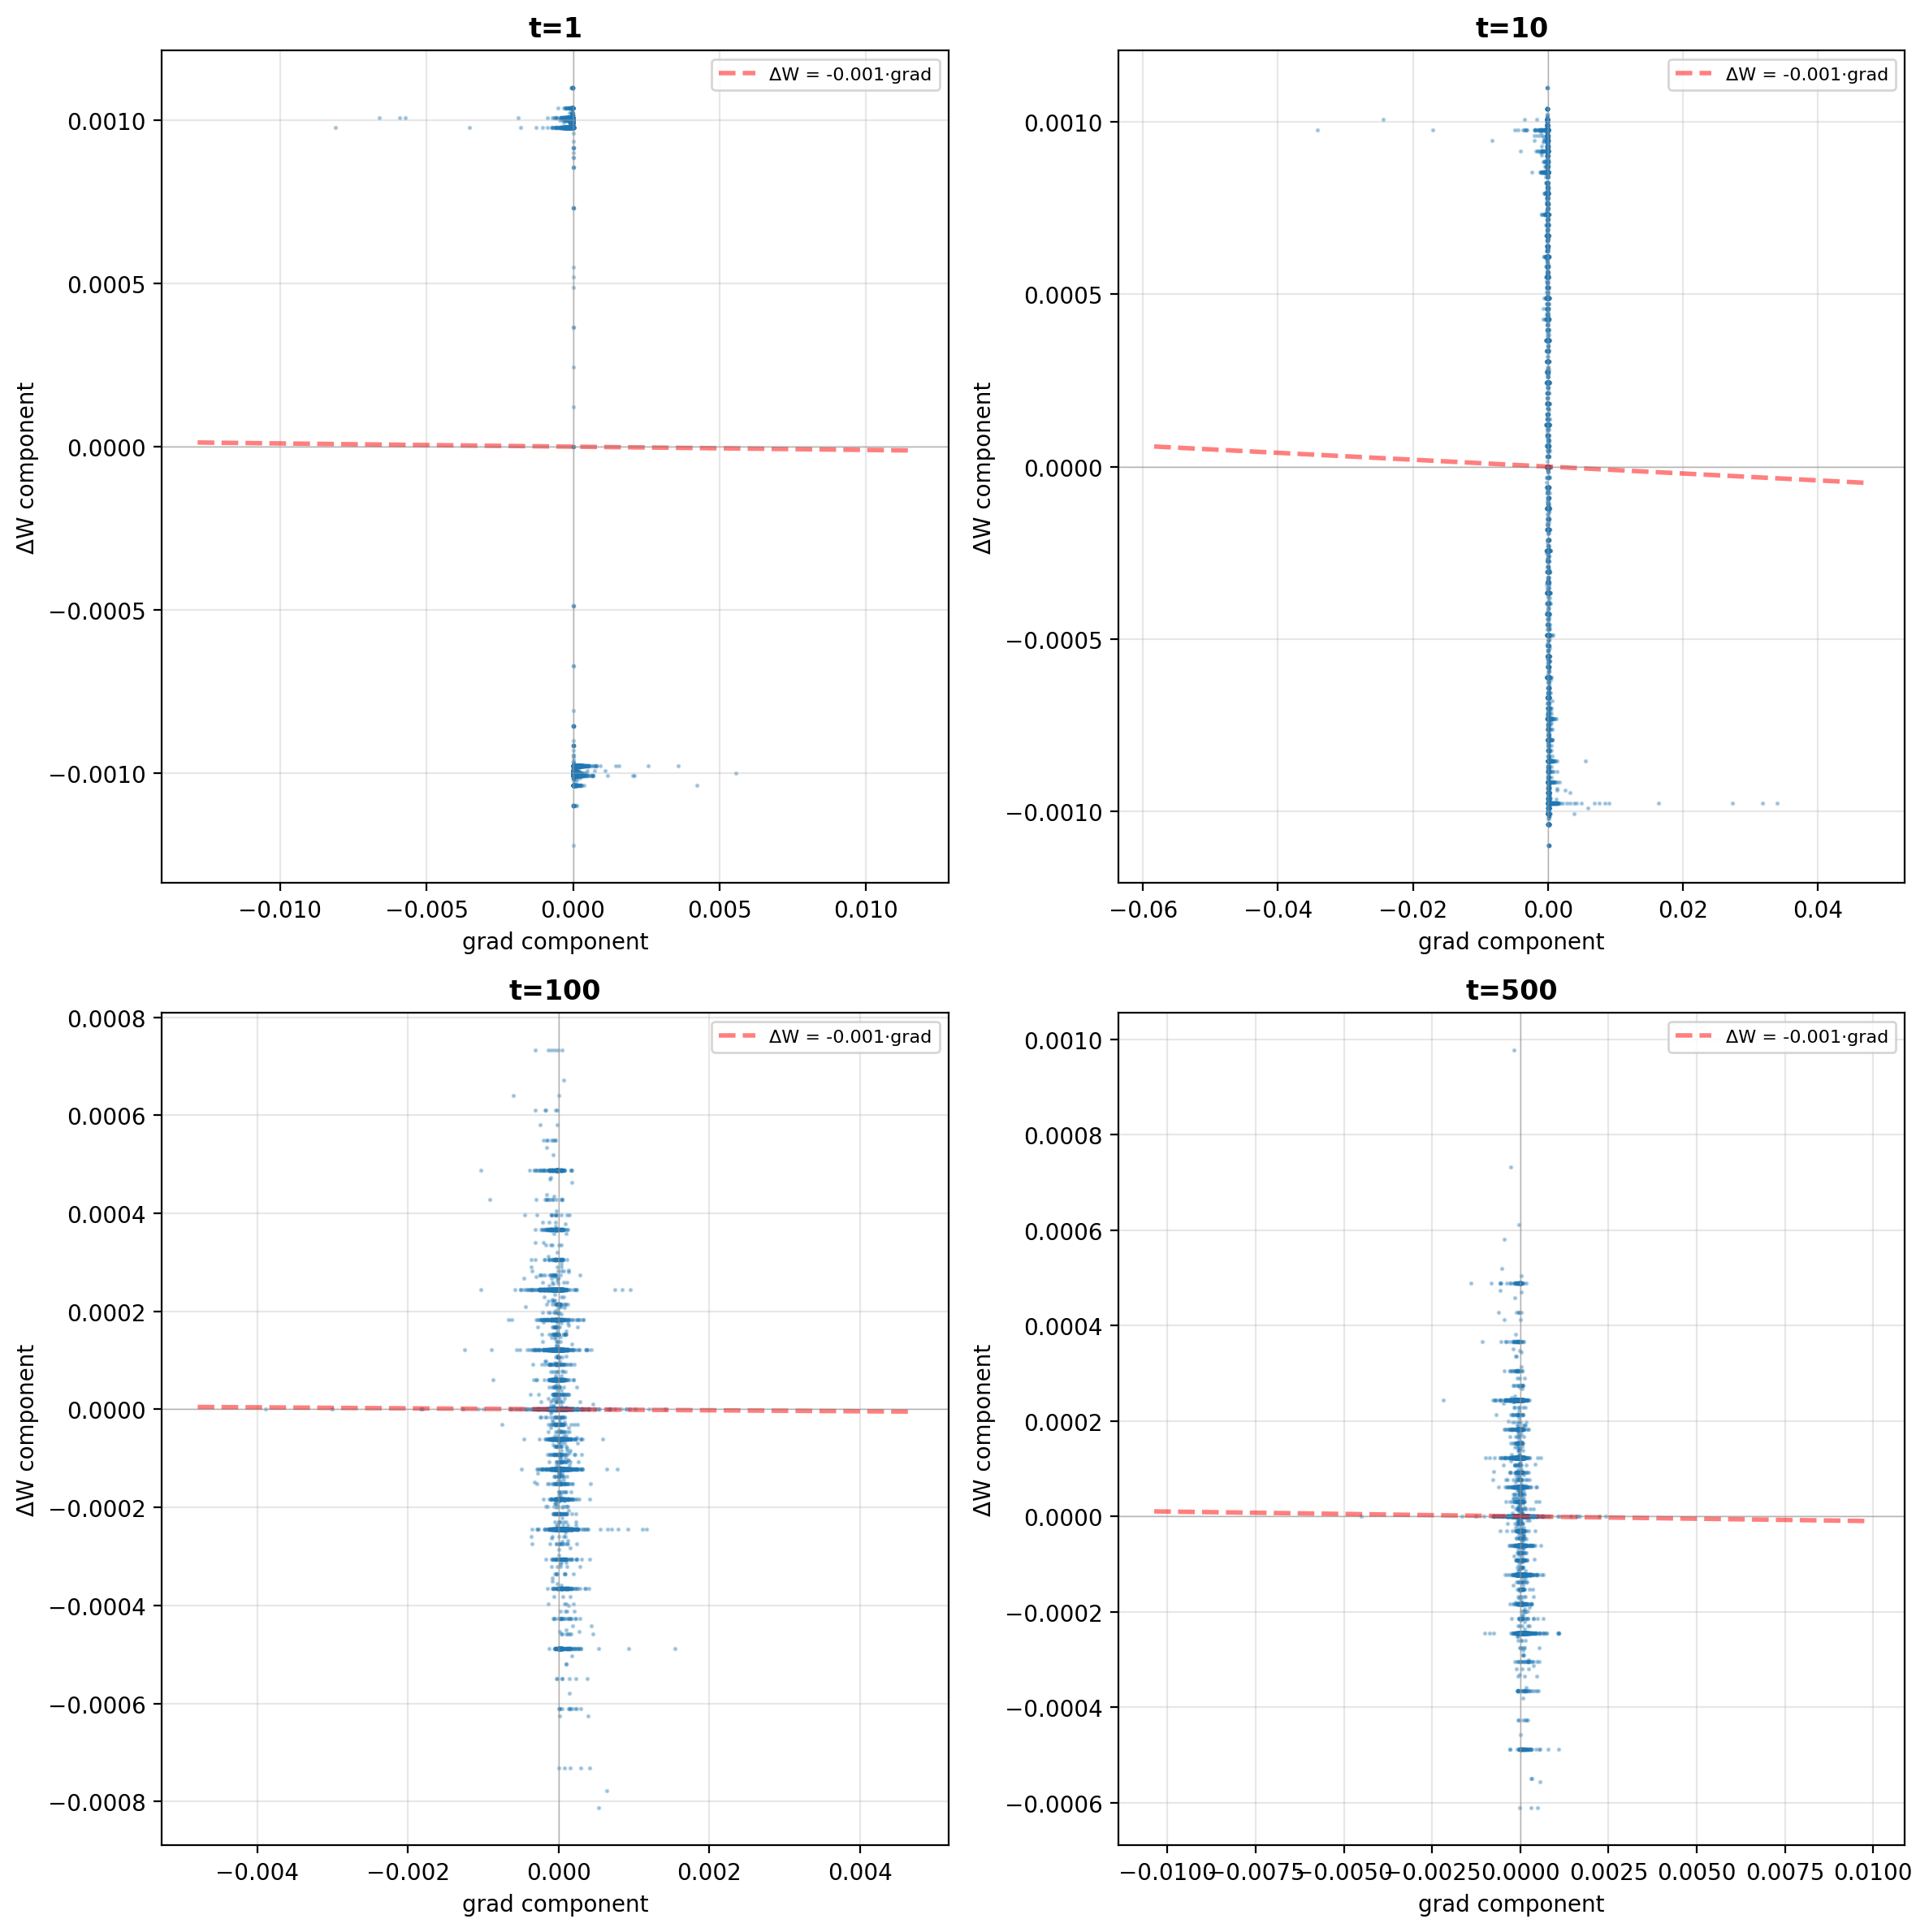

In [10]:
SCATTER_TIMESTEPS = [1, 10, 100, 500]

fig, axes = plt.subplots(2, 2, figsize=(12, 12), dpi=200)
axes = axes.flatten()

for idx, t in enumerate(SCATTER_TIMESTEPS):
    ax = axes[idx]
    
    # Flatten all components
    dW_flat = delta_W[t].cpu().float().flatten().numpy()
    g_flat = grad_W[t].cpu().float().flatten().numpy()
    
    # Sample for plotting (all 640k points is too many)
    n_sample = min(10000, len(dW_flat))
    indices = np.random.choice(len(dW_flat), size=n_sample, replace=False)
    
    ax.scatter(g_flat[indices], dW_flat[indices], s=1, alpha=0.3, rasterized=True)
    
    # Add reference line: ΔW = -0.001·grad
    g_range = np.array([g_flat.min(), g_flat.max()])
    ax.plot(g_range, -0.001 * g_range, 'r--', linewidth=2, alpha=0.5, label='ΔW = -0.001·grad')
    
    ax.set_xlabel('grad component', fontsize=10)
    ax.set_ylabel('ΔW component', fontsize=10)
    ax.set_title(f't={t}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    ax.axhline(0, color='gray', linewidth=0.5, alpha=0.5)
    ax.axvline(0, color='gray', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.show()

## 4. Per-Token Analysis: Live vs Dead

Compare the gradient-ΔW relationship for live vs dead tokens at t=100.

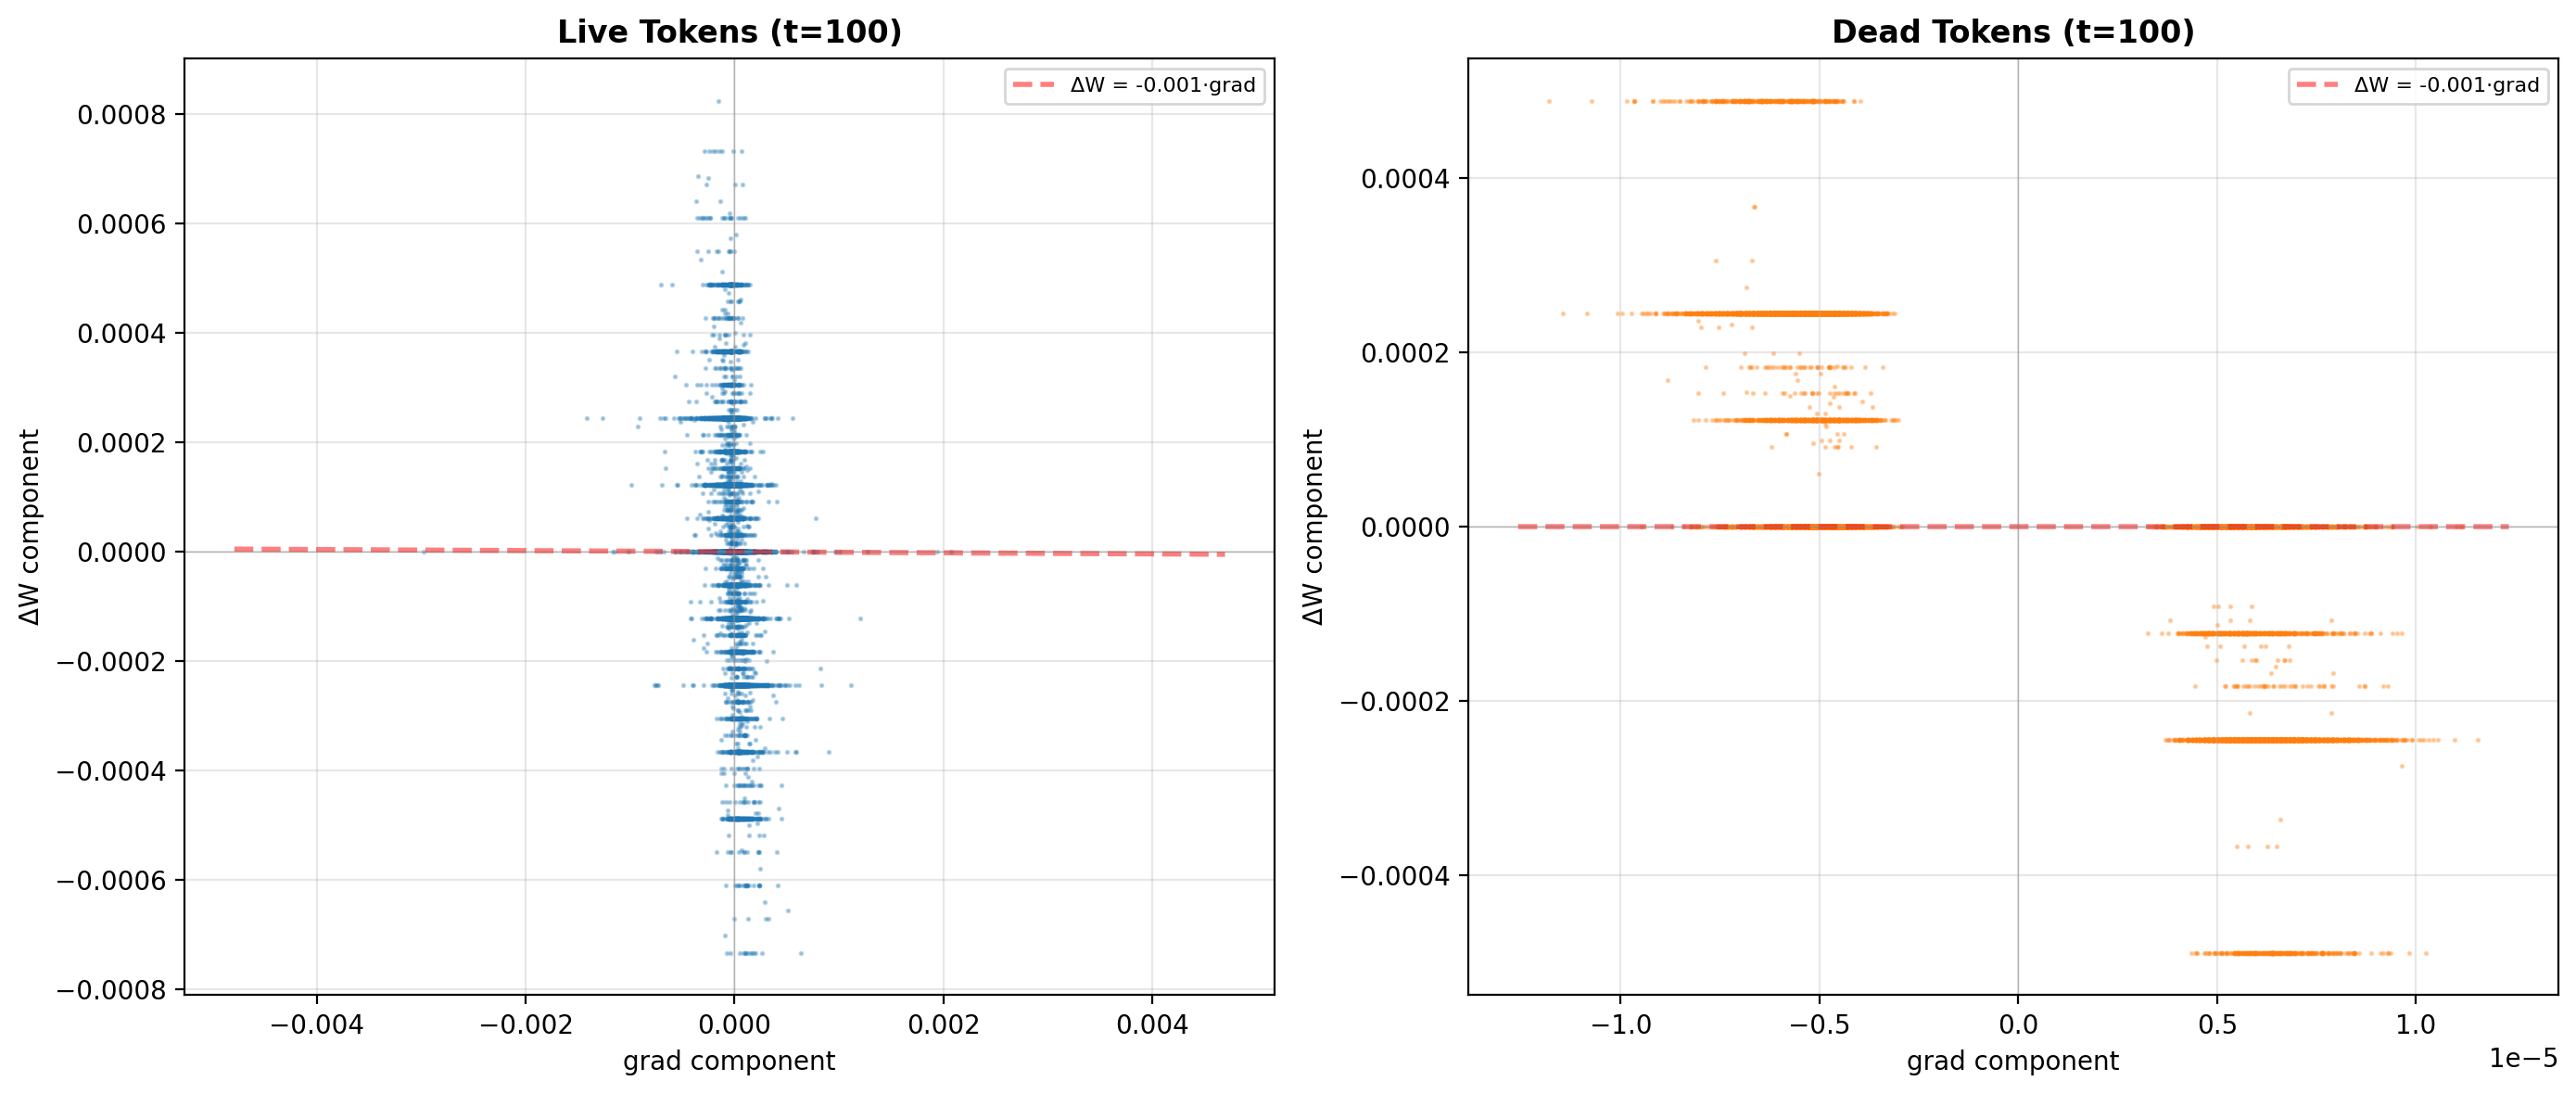

In [11]:
t_inspect = 100

fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=200)

dW = delta_W[t_inspect].cpu().float()
g = grad_W[t_inspect].cpu().float()

# Live tokens
ax = axes[0]
dW_live = dW[live_mask.cpu()].flatten().numpy()
g_live = g[live_mask.cpu()].flatten().numpy()

n_sample = min(10000, len(dW_live))
indices = np.random.choice(len(dW_live), size=n_sample, replace=False)

ax.scatter(g_live[indices], dW_live[indices], s=1, alpha=0.3, rasterized=True)
g_range = np.array([g_live.min(), g_live.max()])
ax.plot(g_range, -0.001 * g_range, 'r--', linewidth=2, alpha=0.5, label='ΔW = -0.001·grad')

ax.set_xlabel('grad component', fontsize=10)
ax.set_ylabel('ΔW component', fontsize=10)
ax.set_title(f'Live Tokens (t={t_inspect})', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)
ax.axhline(0, color='gray', linewidth=0.5, alpha=0.5)
ax.axvline(0, color='gray', linewidth=0.5, alpha=0.5)

# Dead tokens
ax = axes[1]
dW_dead = dW[dead_mask.cpu()].flatten().numpy()
g_dead = g[dead_mask.cpu()].flatten().numpy()

n_sample = min(10000, len(dW_dead))
indices = np.random.choice(len(dW_dead), size=n_sample, replace=False)

ax.scatter(g_dead[indices], dW_dead[indices], s=1, alpha=0.3, rasterized=True, color='C1')
g_range = np.array([g_dead.min(), g_dead.max()])
ax.plot(g_range, -0.001 * g_range, 'r--', linewidth=2, alpha=0.5, label='ΔW = -0.001·grad')

ax.set_xlabel('grad component', fontsize=10)
ax.set_ylabel('ΔW component', fontsize=10)
ax.set_title(f'Dead Tokens (t={t_inspect})', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)
ax.axhline(0, color='gray', linewidth=0.5, alpha=0.5)
ax.axvline(0, color='gray', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.show()

## 5. Null Movement: How many components are frozen?

Count how many ΔW components are exactly zero (bfloat16 can't represent the change).

In [12]:
print("Fraction of ΔW components that are exactly zero:")
print()

frozen_fractions = []

for t in TIMESTEPS:
    dW = delta_W[t]
    n_zero = (dW == 0).sum().item()
    n_total = dW.numel()
    frac = n_zero / n_total
    frozen_fractions.append(frac)
    
    print(f"t={t:3d}: {100*frac:.1f}% frozen ({n_zero:,} / {n_total:,})")

print("\n✓ Frozen fractions computed")

Fraction of ΔW components that are exactly zero:

t=  1: 0.0% frozen (198 / 640,000)
t=  2: 1.7% frozen (10,957 / 640,000)
t=  5: 2.2% frozen (14,347 / 640,000)
t= 10: 1.9% frozen (12,045 / 640,000)
t= 20: 1.9% frozen (12,379 / 640,000)
t= 50: 8.2% frozen (52,592 / 640,000)
t=100: 31.2% frozen (199,868 / 640,000)
t=200: 53.1% frozen (340,137 / 640,000)
t=500: 61.9% frozen (396,268 / 640,000)
t=800: 83.7% frozen (535,519 / 640,000)

✓ Frozen fractions computed


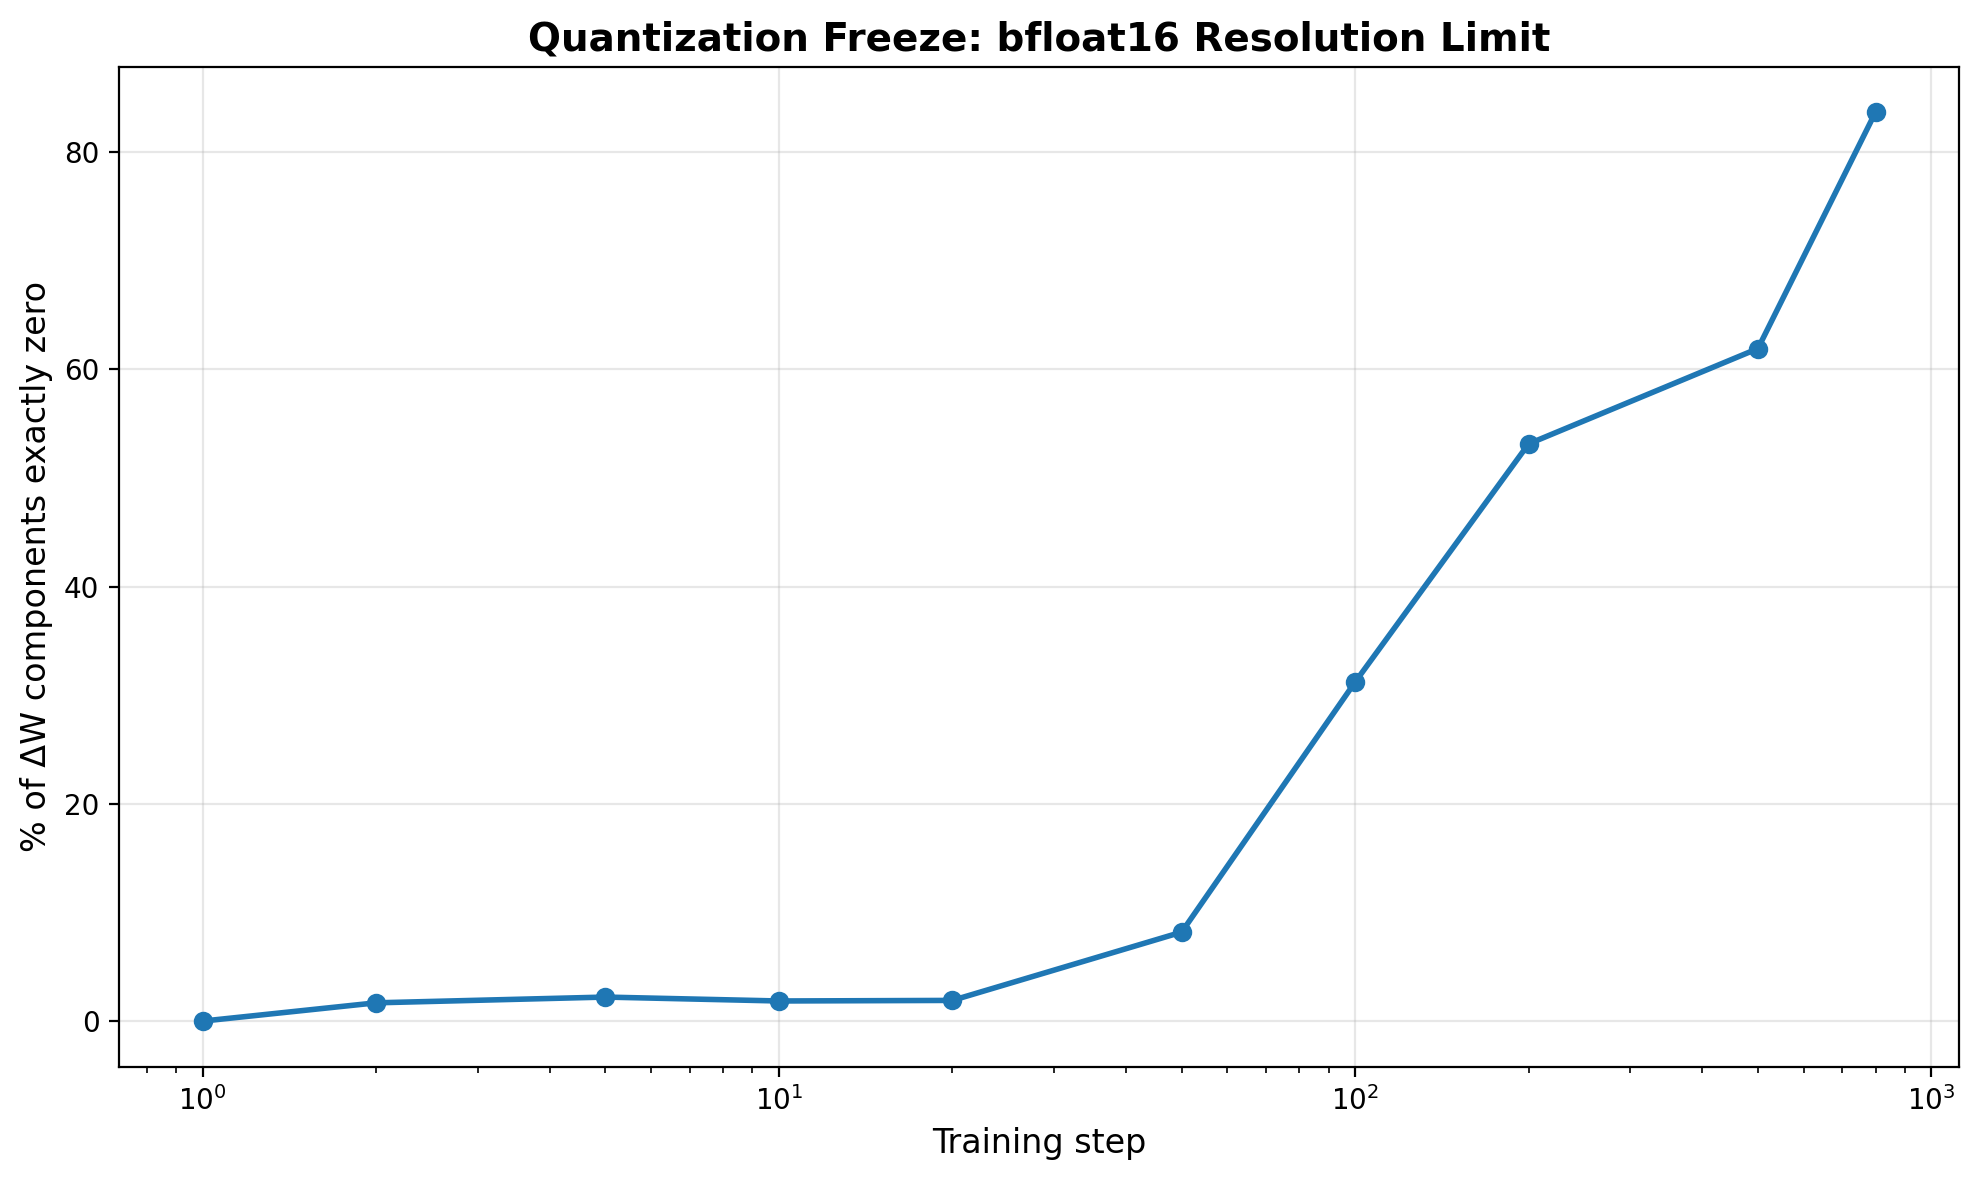

In [13]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

ax.plot(TIMESTEPS, [100*f for f in frozen_fractions], 'o-', linewidth=2, markersize=6)

ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('% of ΔW components exactly zero', fontsize=12)
ax.set_title('Quantization Freeze: bfloat16 Resolution Limit', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xscale('log')

plt.tight_layout()
plt.show()

## Summary

This notebook examines the raw relationship between recorded gradients and measured weight changes before attempting to validate the Adam formula.

**Key questions:**
1. Are gradients and ΔW anticorrelated (negative cosine)?
2. Is the magnitude ratio consistent with learning rate?
3. How does the relationship differ between live and dead tokens?
4. When does quantization start causing problems?